## インストール(初回のみ)
事前に
- pyenv をインストール
- `pyenv install 3.8.13` を実行

しておく

In [ ]:
!sh install.sh

---

In [1]:
# 仮想環境ディレクトリのパッケージを使うため
import site
site.addsitedir('env/lib/python3.8/site-packages')

In [2]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio

/Users/Masaki/.pyenv/versions/3.8.13/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## IO

In [3]:
from utils.audio.wave import load_wave, metadata_wave
from utils.audio.plot import show_spec, show_wave

In [4]:
def show(znt, fs):
    display(Audio(data=znt, rate=fs))

    fig, axes = plt.subplots(2, 1, figsize=(16, 4), tight_layout=True)

    show_wave(znt, fs, ax=axes[0], color='b')

    axes[0].tick_params(axis='x', bottom=False, labelbottom=False)
    axes[0].set_xlim([0, znt.shape[-1]/fs])
    axes[0].set_xlabel('')

    show_spec(znt, fs, stft_dict['n_fft'], ax=axes[1])

    plt.show()

In [5]:
filename = 'data/trim.wav'
data, fs = load_wave(filename)

# show(data, fs)

xnt = data[:, fs*10:fs*70]

## BSS
分離パラメータの詳細は pyroomacoustics から確認
> https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.bss.html
- AuxIVA
- FastMNMF
- ILRMA

以下，使用は非推奨

自己実装
- ~~NMFLGM~~

GPUテンソルでのデバッグがまだ(CPU上では動く)
> https://github.com/onolab-tmu/overiva
- ~~OverIVA~~
- ~~OGIVE~~

In [ ]:
from utils.audio.bss.auxiva import AuxIVA
from utils.audio.bss.fastmnmf import FastMNMF
from utils.audio.bss.ilrma import ILRMA

# from utils.audio.bss.lgm import NMFLGM
# from utils.audio.bss.overiva import OverIVA
# from utils.audio.bss.ogive import OGIVE

In [ ]:
stft_dict = dict(n_fft=1024, hop_length=256, window=torch.hann_window)
device = 'cpu'
model = AuxIVA(**stft_dict).to(device)

In [ ]:
ynt = model(xnt.to(device), n_iter=100)
_ = [show(yt, fs) for yt in ynt]

## Remove silence

In [18]:
from utils.audio import silence_pyaudioanalysis
from utils.audio.transform import extract_from_sections

In [21]:
nonsilent_sections, prob_dict = silence_pyaudioanalysis.silence_removal(
    xnt, fs, 1000, 500,
    min_nonsilence_ms=200, smooth_window_ms=500,
    weight=.5,
    return_prob=True
)

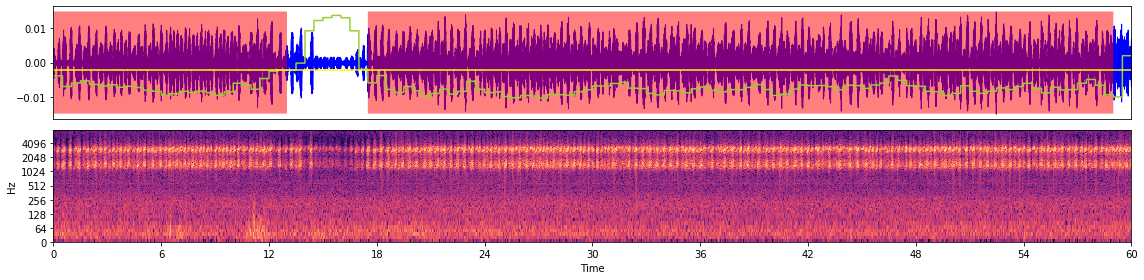

In [28]:
stft_dict = dict(n_fft=1024, hop_length=256, window=torch.hann_window)

pr, pr_thr = prob_dict['probability'], prob_dict['threshold']
pr_ms = pr[:, None].tile((1, 500)).view(-1)

d_min, d_max = xnt.mean(0).min().item(), xnt.mean(0).max().item()
d_min, d_max = min(d_min, -abs(d_max)), max(d_max, abs(d_min))
nonsilence = d_min*torch.ones(xnt.shape[-1]*1000//fs)
for sec in nonsilent_sections:
    nonsilence[sec[0]:sec[1]] = d_max

fig, axes = plt.subplots(2, 1, figsize=(16, 4), tight_layout=True)

show_wave(xnt, fs, ax=axes[0], color='b')

x_ms = torch.linspace(0, xnt.shape[-1]/fs, steps=nonsilence.shape[0])
axes[0].fill_between(x_ms, nonsilence, d_min, facecolor='r', alpha=.5)
axes[0].plot(x_ms, d_min+(d_max-d_min)*pr_ms, color='yellowgreen')
axes[0].axhline(y=d_min+(d_max-d_min)*pr_thr, color='yellow')

axes[0].tick_params(axis='x', bottom=False, labelbottom=False)
axes[0].set_xlim([0, xnt.shape[-1]/fs])
axes[0].set_xlabel('')

show_spec(xnt, fs, stft_dict['n_fft'], ax=axes[1])

plt.show()

In [ ]:
extracted = extract_from_sections(xnt, fs, nonsilent_sections)

In [6]:
from utils.audio import silence_pydub

In [7]:
silence_pydub.silence_removal(xnt, fs, seek_ms=100, threshold=-60)

[[0, 14500], [16800, 60000]] {'probability': tensor([0.0035, 0.0036, 0.0036, 0.0035, 0.0036, 0.0040, 0.0037, 0.0035, 0.0036,
        0.0037, 0.0036, 0.0036, 0.0037, 0.0037, 0.0041, 0.0037, 0.0037, 0.0038,
        0.0038, 0.0040, 0.0038, 0.0039, 0.0039, 0.0038, 0.0038, 0.0039, 0.0039,
        0.0038, 0.0042, 0.0040, 0.0038, 0.0038, 0.0040, 0.0043, 0.0039, 0.0039,
        0.0038, 0.0039, 0.0038, 0.0038, 0.0037, 0.0042, 0.0041, 0.0038, 0.0039,
        0.0039, 0.0044, 0.0043, 0.0041, 0.0040, 0.0044, 0.0041, 0.0040, 0.0041,
        0.0041, 0.0044, 0.0040, 0.0042, 0.0042, 0.0045, 0.0043, 0.0043, 0.0044,
        0.0043, 0.0046, 0.0043, 0.0043, 0.0041, 0.0044, 0.0042, 0.0042, 0.0041,
        0.0042, 0.0044, 0.0041, 0.0042, 0.0044, 0.0046, 0.0044, 0.0044, 0.0042,
        0.0046, 0.0044, 0.0044, 0.0043, 0.0045, 0.0043, 0.0043, 0.0041, 0.0042,
        0.0045, 0.0043, 0.0043, 0.0043, 0.0045, 0.0041, 0.0041, 0.0040, 0.0040,
        0.0037, 0.0038, 0.0038, 0.0039, 0.0038, 0.0040, 0.0041, 0.0041, 0.0

[[0, 14500], [16800, 60000]]

In [30]:
axes[0].collections[0].remove()

In [11]:
960000/fs*1000/100

600.0

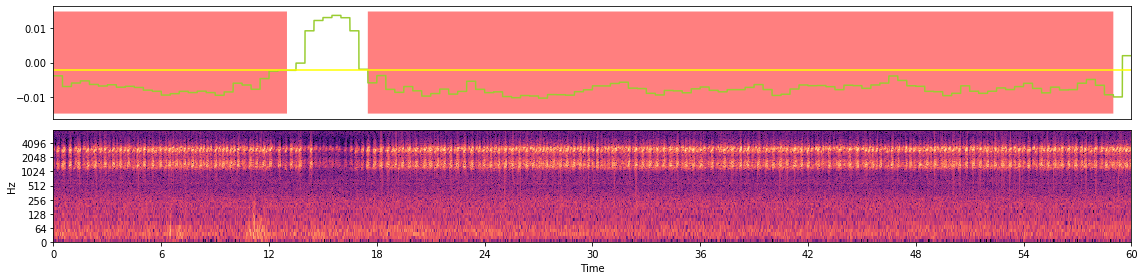

In [31]:
fig

In [32]:
[0][1:]

[]